In [1]:
import datasets
from src.models.components.partmae_v4 import (
    PARTMaskedAutoEncoderViT,
    PART_mae_vit_base_patch16_dec512d8b,
)
from src.data.components.transforms.multi_crop_v2 import ParametrizedMultiCropV2
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import MeanSquaredError, MeanMetric, MetricCollection
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import math
import timm
import timm.scheduler
import torch.optim
import logging
from functools import partial
from src.utils.visualization.reconstruction_v4_gt import reconstruction_gt
from torchvision.transforms.v2.functional import to_image

logging.basicConfig(level=logging.INFO)

In [2]:
# SEED = 447702614369231012
SEED = 1
# set seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
from PIL import Image
from jaxtyping import Float
from torch import Tensor
import torch
import parameterized_transforms.transforms as ptx
import parameterized_transforms.wrappers as ptw
from torch.utils.data import default_collate


class ParametrizedMultiCropV2(object):
    def __init__(
        self,
        canonical_size: int = 512,
        global_size: int = 224,
        local_size: int = 96,
        canonical_crop_scale=(0.9, 1.0),
        global_crops_scale: tuple[float, float] = (0.25, 1.0),
        local_crops_scale: tuple[float, float] = (0.05, 0.25),
        n_global_crops: int = 2,
        n_local_crops: int = 8,
    ):
        # scale params from
        # https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/args.txt
        self.canonical_size = canonical_size
        self.canonical_crop_scale = canonical_crop_scale
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.n_global_crops = n_global_crops
        self.n_local_crops = n_local_crops

        self.canonicalize = ptw.CastParamsToTensor(
            transform=ptx.RandomResizedCrop(
                canonical_size, scale=canonical_crop_scale, interpolation=Image.BICUBIC
            )
        )
        normalize = ptx.Compose(
            [
                ptx.ToTensor(),
            ]
        )
        self.global_ttx = ptw.CastParamsToTensor(
            transform=ptx.Compose(
                [
                    ptx.RandomResizedCrop(
                        global_size,
                        scale=global_crops_scale,
                        interpolation=Image.BICUBIC,
                    ),
                    normalize,
                ]
            )
        )
        self.local_ttx = ptw.CastParamsToTensor(
            transform=ptx.Compose(
                [
                    ptx.RandomResizedCrop(
                        local_size, scale=local_crops_scale, interpolation=Image.BICUBIC
                    ),
                    normalize,
                ]
            )
        )
        self.max_scale_ratio = self.compute_max_scale_ratio_aug()

    def __call__(self, image: Image.Image):
        Nl = self.n_local_crops
        Ng = self.n_global_crops

        image, canon_params = self.canonicalize(image.convert("RGB"))

        global_crops, global_params = default_collate(
            [self.global_ttx(image) for _ in range(self.n_global_crops)]
        )
        local_crops, local_params = default_collate(
            [self.local_ttx(image) for _ in range(self.n_local_crops)]
        )

        canon_params: Tensor = canon_params.unsqueeze(0)
        local_params = torch.cat([canon_params.expand(Nl, -1), local_params], 1)
        global_params = torch.cat([canon_params.expand(Ng, -1), global_params], 1)
        return global_crops, global_params, local_crops, local_params

    def recreate_local(
        self, canonical_img: Float[Tensor, "C H W"], local_params: Float[Tensor, "N 4"]
    ) -> Float[Tensor, "C H W"]:
        """
        Recreate the local image from the image and local parameters.
        """
        return [
            self.local_ttx.transform.transforms[0].consume_transform(
                canonical_img, local_params[i].tolist()
            )[0]
            for i in range(local_params.shape[0])
        ]

    def recreate_global(
        self, canonical_img: Float[Tensor, "C H W"], global_params: Float[Tensor, "N 4"]
    ) -> Float[Tensor, "C H W"]:
        """
        Recreate the global image from the image and global parameters.
        """
        return [
            self.global_ttx.transform.transforms[0].consume_transform(
                canonical_img, global_params[i].tolist()
            )[0]
            for i in range(global_params.shape[0])
        ]

    def recreate_canonical(
        self, image: Float[Tensor, "C H W"], canonical_params: Float[Tensor, "4"]
    ) -> Float[Tensor, "C H W"]:
        """
        Recreate the canonical image from the image and canonical parameters.
        """
        return self.canonicalize.transform.consume_transform(
            image, canonical_params.tolist()
        )[0]

    def compute_max_scale_ratio_aug(self) -> float:
        grrc = self.global_ttx.transform.transforms[0]
        lrrc = self.local_ttx.transform.transforms[0]
        scale_min = min(*grrc.scale, *lrrc.scale)
        scale_max = max(*grrc.scale, *lrrc.scale)
        ratio_min = min(*grrc.ratio, *lrrc.ratio)
        ratio_max = max(*grrc.ratio, *lrrc.ratio)
        max_ratio = ((scale_max * ratio_max) / (scale_min * ratio_min)) ** 0.5
        return max_ratio

In [4]:
n_global_crops = 1
n_local_crops = 4
train_transform = ParametrizedMultiCropV2(
    n_global_crops=n_global_crops,
    n_local_crops=n_local_crops,
    local_crops_scale=(0.05, 0.3),
)
print(train_transform.compute_max_scale_ratio_aug())

5.962847939999438


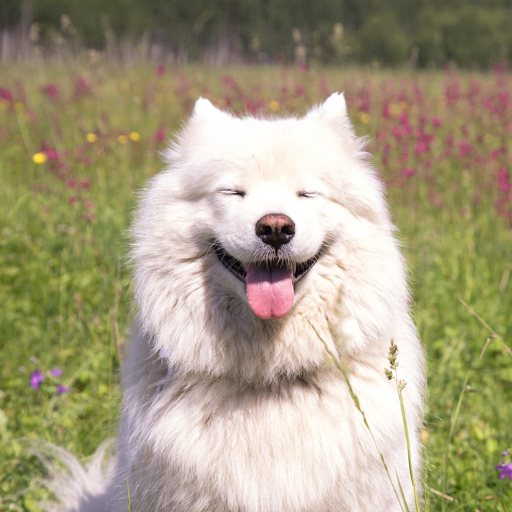

In [5]:
img_tensor = Image.open("../../artifacts/samoyed.jpg")
img_tensor = img_tensor.crop((0, 0, 1000, 1000))
img_tensor.resize((512, 512))

In [6]:
torch.set_float32_matmul_precision("medium")

patch_size = 32
model = PARTMaskedAutoEncoderViT(
    patch_size=patch_size,
    canonical_img_size=512,
    max_scale_ratio=6.0,
    mask_ratio=0.75,
    pos_mask_ratio=0.75,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    sampler="stratified_jittered",
    verbose=True,
)

inputs = train_transform(img_tensor)
inputs = [torch.stack([x], dim=0) for x in inputs]
with torch.no_grad():
    out = model(*inputs)

In [7]:
# torch.save(inputs, "inputs.pth")

In [8]:
out["g_patch_positions_vis"].shape

torch.Size([1, 12, 2])

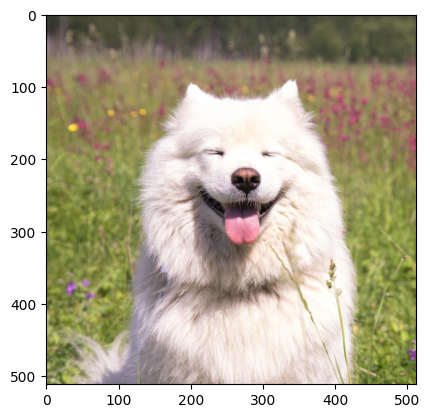

In [9]:
cx = train_transform.recreate_canonical(
    img_tensor, inputs[1][0, 0, :4]
)  # gp-ix=1, bs=0, view=0

# plot a bounding box on all local crops
# imshow cx
plt.imshow(cx)

In [10]:
from jaxtyping import Int
from torch import Tensor
from torchvision.transforms.v2.functional import to_tensor


def mask_image(img, patch_positions_vis, patch_positions_nopos, patch_size=16):
    if isinstance(img, Image.Image):
        img = to_tensor(img)
    new_img = torch.zeros_like(img)
    for pos in patch_positions_vis:
        x, y = pos
        patch = img[:, y : y + patch_size, x : x + patch_size]
        # darken the patch
        patch = patch * 0.25
        # make the 0, 0 corner red
        # patch[:, 0, 0] = 1.0
        new_img[:, y : y + patch_size, x : x + patch_size] = patch

    for pos in patch_positions_nopos:
        x, y = pos
        patch = img[:, y : y + patch_size, x : x + patch_size]
        new_img[:, y : y + patch_size, x : x + patch_size] = patch

    return new_img


def extract_patches(img, patch_positions_vis, ids_remove_pos, patch_size):
    if isinstance(img, Image.Image):
        img = to_tensor(img)
    patches = []
    for i, pos in enumerate(patch_positions_vis):
        x, y = pos
        if i in ids_remove_pos:
            patch = img[:, y : y + patch_size, x : x + patch_size]
        else:
            patch = img[:, y : y + patch_size, x : x + patch_size] * 0.25

        patches.append(patch)
    return patches


def plot_patches_as_column(patches, max_patches=1000):
    # plot patches as a column
    new_img = torch.cat(patches[:max_patches], dim=1)
    return new_img


def reshape_patch_positions(
    patch_positions_vis: Int[Tensor, "B*V N_vis 2"],
    patch_positions_nopos: Int[Tensor, "B V*N_nopos 2"],
    shapes: tuple[int, int, int],
):
    H, N_nopos, V = shapes
    B, _, _ = patch_positions_nopos.shape
    patch_positions_nopos = patch_positions_nopos.unflatten(1, (V, N_nopos))
    patch_positions_vis = patch_positions_vis.unflatten(0, (B, V))
    return patch_positions_vis, patch_positions_nopos


def clean_model_io(batch: tuple, out: dict, device="cuda"):
    """
    Cleans and reshapes model outputs for visualization.

    - Detach and move tensors to device.
    - Adds useful tensors to dict (crop_params, canonical_params)
    """
    io = dict()

    io["g_x"] = batch[0]
    io["g_params"] = batch[1]
    io["l_x"] = batch[2]
    io["l_params"] = batch[3]

    for pfx in ["g", "l"]:
        io[f"{pfx}_crop_params"] = io[f"{pfx}_params"][:, :, 4:8]

    io[f"canonical_params"] = io[f"g_params"][:, 0, :4]

    io.update({name: out[name] for name in out.keys()})

    ## MOVE TO DEVICE and DETACH
    clean = lambda x: x.to(device).detach() if isinstance(x, Tensor) else x
    io = {name: clean(tensor) for name, tensor in io.items()}
    return io

In [11]:
io = clean_model_io(inputs, out, device="cpu")

In [12]:
print(out["l_patch_positions_vis"].shape)
print(out["l_patch_positions_nopos"].shape)
print(out["l_shapes"])
ppv, ppn = reshape_patch_positions(
    out["l_patch_positions_vis"], out["l_patch_positions_nopos"], out["l_shapes"]
)
print(ppv.shape)
print(ppn.shape)
# print(reshape_nopos(out["l_patch_positions_nopos"], out["l_shapes"]).shape)
#
# print(out["g_patch_positions_vis"].shape)
# print(reshape_nopos(out["g_patch_positions_nopos"], out["g_shapes"]).shape)
#
# print(out["l_shapes"])

torch.Size([4, 2, 2])
torch.Size([1, 8, 2])
(96, 2, 4)
torch.Size([1, 4, 2, 2])
torch.Size([1, 4, 2, 2])


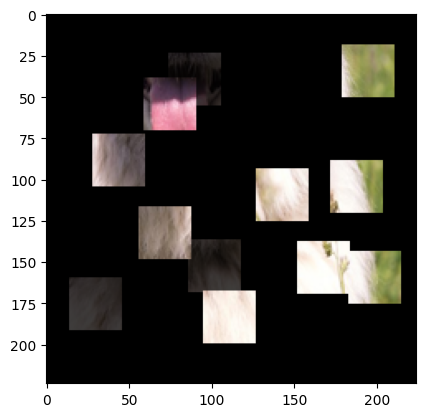

In [13]:
# gx_unnorm = train_transform.recreate_global(cx, inputs[1][0, :, 4:])
fig, ax = plt.subplots(1, n_global_crops, squeeze=False)
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["g_patch_positions_vis"], out["g_patch_positions_nopos"], out["g_shapes"]
)
for i in range(n_global_crops):
    x = mask_image(
        io["g_x"][0][i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax[0][i].imshow(x.permute(1, 2, 0))

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])


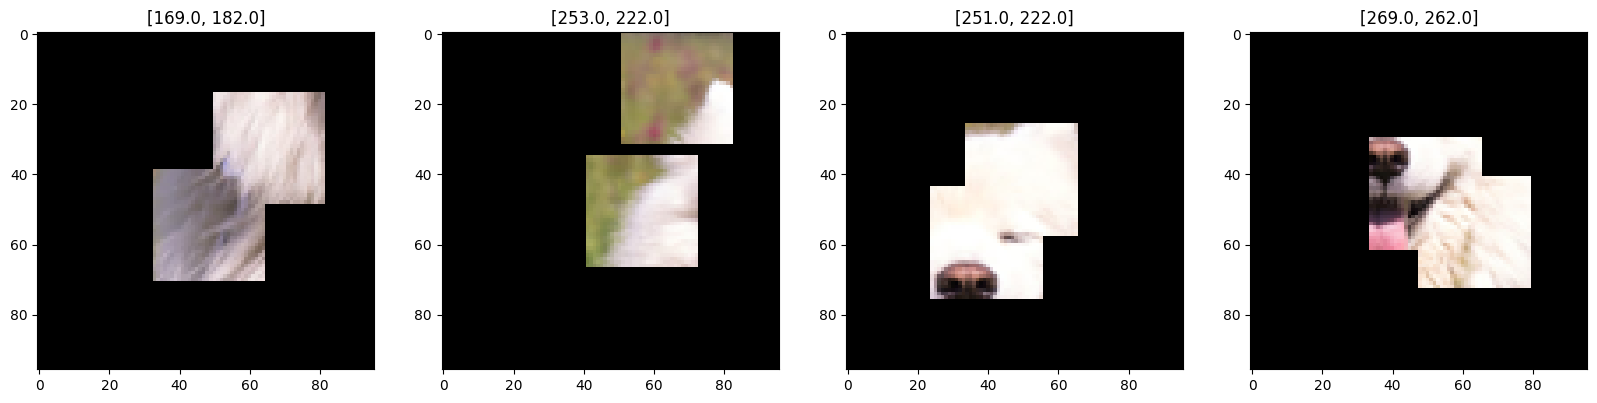

In [14]:
lx_unnorm = train_transform.recreate_local(cx, inputs[3][0, :, 4:])
fig, ax = plt.subplots(1, n_local_crops, figsize=(20, 10))
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["l_patch_positions_vis"], out["l_patch_positions_nopos"], out["l_shapes"]
)
for i in range(n_local_crops):
    x = mask_image(
        io["l_x"][0][i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax[i].imshow(x.permute(1, 2, 0))
    # title as scale
    print(inputs[3][0, i, :].shape)
    ax[i].set_title(f"{inputs[3][0, i, 6:].tolist()}")

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])


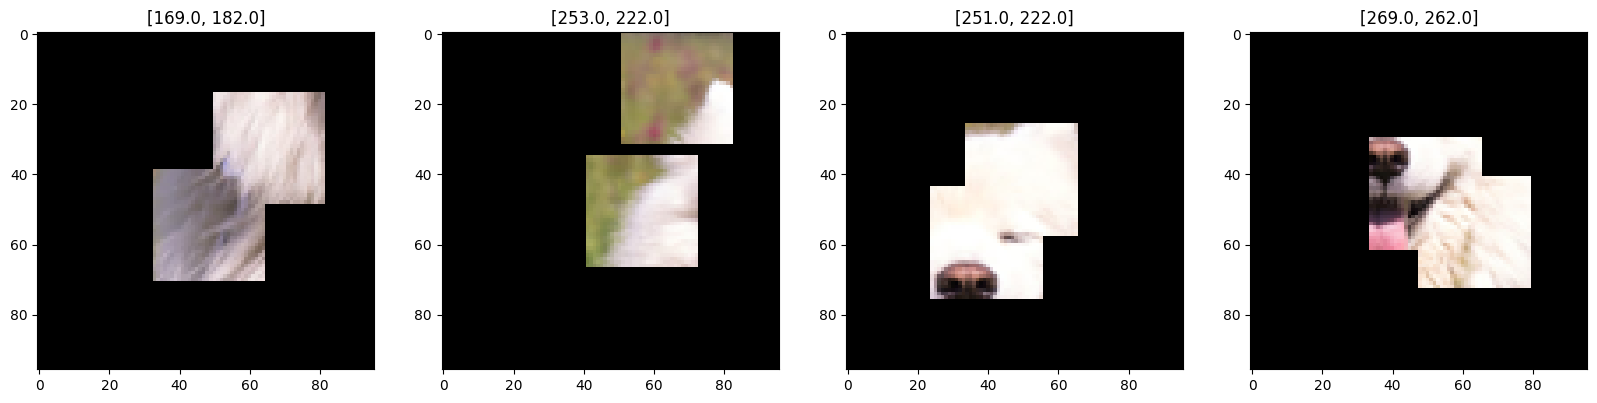

In [15]:
lx_unnorm = train_transform.recreate_local(cx, inputs[3][0, :, 4:])
fig, ax = plt.subplots(1, n_local_crops, figsize=(20, 10))
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["l_patch_positions_vis"], out["l_patch_positions_nopos"], out["l_shapes"]
)
for i in range(n_local_crops):
    x = mask_image(
        io["l_x"][0][i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax[i].imshow(x.permute(1, 2, 0))
    # title as scale
    print(inputs[3][0, i, :].shape)
    ax[i].set_title(f"{inputs[3][0, i, 6:].tolist()}")

In [16]:
print(patch_positions_vis.shape)
print(io["l_ids_remove_pos"].shape)
print(io["l_x"].shape)
print(io["l_params"].shape)
print(io["l_shapes"])

torch.Size([1, 4, 2, 2])
torch.Size([4, 2])
torch.Size([1, 4, 3, 96, 96])
torch.Size([1, 4, 8])
(96, 2, 4)


In [17]:
io.keys()

dict_keys(['g_x', 'g_params', 'l_x', 'l_params', 'g_crop_params', 'l_crop_params', 'canonical_params', 'g_patch_positions_nopos', 'l_patch_positions_nopos', 'g_shapes', 'l_shapes', 'g_patch_positions_vis', 'l_patch_positions_vis', 'g_ids_remove_pos', 'l_ids_remove_pos', 'loss_intra_t', 'loss_inter_t', 'loss_intra_s', 'loss_inter_s', 'loss_t', 'loss_s', 'loss', 'pred_dT', 'gt_dT'])

patch shape torch.Size([1, 3, 32, 32])
patch shape torch.Size([1, 3, 32, 32])


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


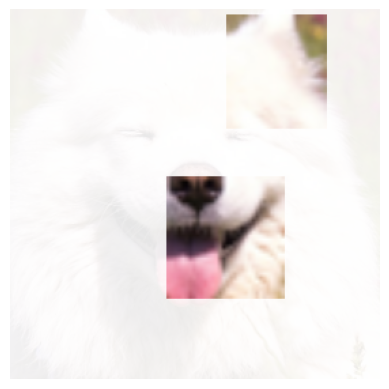

In [18]:
from torch.nn import functional as F

ids = [(3, 0), (2, 0)]  # mouth, nose
grey = 0.1
base_img = to_tensor(cx).clone()
# make base_img whitened
base_img = base_img * grey + (1 - grey)  # blend with white
for v, idx_in_local_crop in ids:
    crop_size, N, V = io["l_shapes"]
    pos = io["l_patch_positions_nopos"][0].view(V, N, 2)[v][idx_in_local_crop] 
    y_crop, x_crop = int(round(pos[0].item())), int(round(pos[1].item()))
    patch = io["l_x"][0][v][
        :, y_crop : y_crop + patch_size, x_crop : x_crop + patch_size
    ]
    origin = io["l_crop_params"][0, v, :2]
    size = io["l_crop_params"][0, v, 2:]
    canonical_pos = origin + (pos / crop_size) * size
    scale_y = size[0] / crop_size
    scale_x = size[1] / crop_size
    canonical_pos = origin + (pos / crop_size) * size
    y_can, x_can = int(round(canonical_pos[0].item())), int(
        round(canonical_pos[1].item())
    )

    new_patch_h = int(round(float(patch_size * scale_y)))
    new_patch_w = int(round(float(patch_size * scale_x)))
    # interpolate to global size
    patch = patch.unsqueeze(0)
    print("patch shape", patch.shape)
    patch_resized = F.interpolate(
        patch,
        size=(new_patch_h, new_patch_w),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)

    base_img[
        :, y_can : y_can + new_patch_h, x_can : x_can + new_patch_w
    ] = patch_resized
    # plt.imshow(patch[0].permute(1, 2, 0))
    # plt.axis("off")
    # plt.show()

# remove 100px from the borders
base_img = base_img[:, 100:-140, 140:-100]
plt.axis('off')
plt.imshow(base_img.permute(1, 2, 0))
# savefig with high dpi
plt.savefig(
    "base_img.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0,
)

# # mouth_params = (patch_positions_vis[0][0)] + inputs[3][0, 3, 4:6]
#
# # to global coordinates
# # mouth_params =
#
# nose_patch = extract_patches(io["l_x"][0][2], patch_positions_vis[0][2], io["l_ids_remove_pos"][2], patch_size)[0]
# plt.imshow(mouth_patch.permute(1, 2, 0))
# plt.axis('off')
# plt.show()
# plt.imshow(nose_patch.permute(1, 2, 0))
# plt.axis('off')
# plt.show()# hi

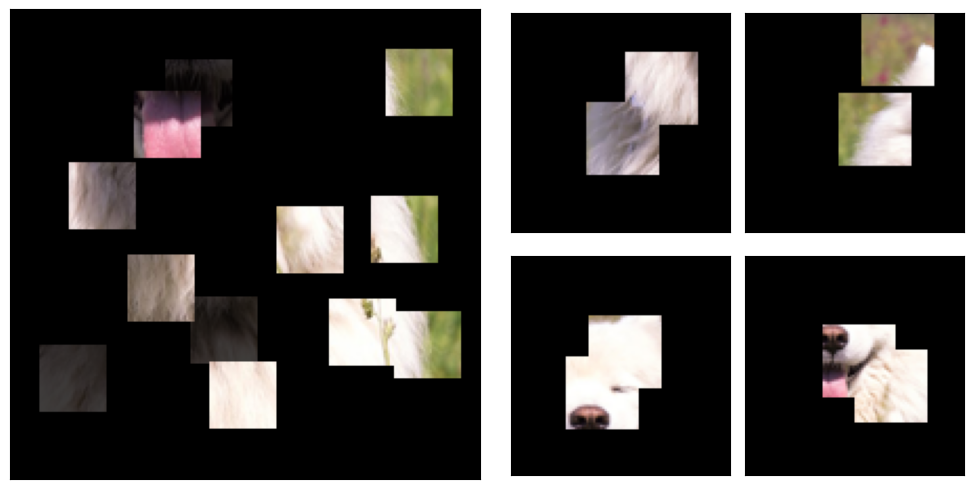

In [19]:
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(10, 5))

# Create a grid with 2 rows and 3 columns with width ratios to account for image size differences
gs = gridspec.GridSpec(2, 3, width_ratios=[2.3, 1, 1])

# Global image spans first column (both rows)
ax_global = fig.add_subplot(gs[:, 0])

# Local images in a 2x2 grid in columns 1 and 2
ax_local = [
    fig.add_subplot(gs[0, 1]),  # Top-left local
    fig.add_subplot(gs[0, 2]),  # Top-right local
    fig.add_subplot(gs[1, 1]),  # Bottom-left local
    fig.add_subplot(gs[1, 2]),  # Bottom-right local
]

# Display global image
gx_unnorm = train_transform.recreate_global(cx, inputs[1][0, :, 4:])
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["g_patch_positions_vis"], out["g_patch_positions_nopos"], out["g_shapes"]
)
for i in range(n_global_crops):
    x = mask_image(
        gx_unnorm[i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax_global.imshow(x.permute(1, 2, 0), aspect="equal")
    # ax_global.set_title(f"Global Image (224x224)")

# Display local images
lx_unnorm = train_transform.recreate_local(cx, inputs[3][0, :, 4:])
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["l_patch_positions_vis"], out["l_patch_positions_nopos"], out["l_shapes"]
)
for i in range(min(4, n_local_crops)):  # Use just 4 local crops
    x = mask_image(
        lx_unnorm[i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax_local[i].imshow(x.permute(1, 2, 0), aspect="equal")
    # ax_local[i].set_title(f"Local {i+1}: {inputs[3][0, i, 6:].tolist()} (96x96)")

# Remove axis ticks for cleaner look
for ax in [ax_global] + ax_local:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

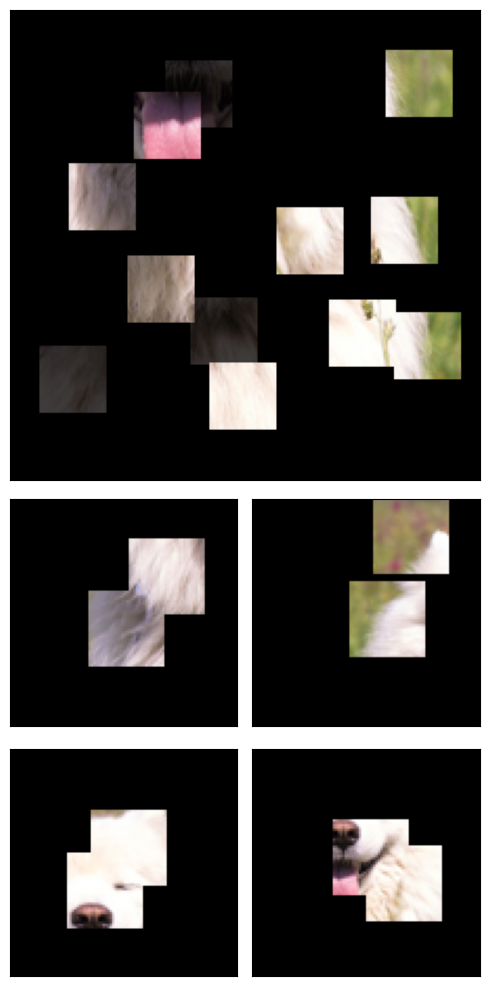

In [20]:
import matplotlib.gridspec as gridspec

# Create figure with adjusted dimensions for the new layout
fig = plt.figure(figsize=(5, 10))

# Create a grid with 3 rows and 2 columns
# First row for global image, second and third rows for local images in a 2x2 grid
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1])

# Global image spans the entire first row
ax_global = fig.add_subplot(gs[0, :])

# Create a 2x2 grid for local images
ax_local = [
    fig.add_subplot(gs[1, 0]),  # Top-left
    fig.add_subplot(gs[1, 1]),  # Top-right
    fig.add_subplot(gs[2, 0]),  # Bottom-left
    fig.add_subplot(gs[2, 1]),  # Bottom-right
]

# Display global image
gx_unnorm = train_transform.recreate_global(cx, inputs[1][0, :, 4:])
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["g_patch_positions_vis"], out["g_patch_positions_nopos"], out["g_shapes"]
)
for i in range(n_global_crops):
    x = mask_image(
        gx_unnorm[i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax_global.imshow(x.permute(1, 2, 0), aspect="equal")

# Display local images
lx_unnorm = train_transform.recreate_local(cx, inputs[3][0, :, 4:])
patch_positions_vis, patch_positions_nopos = reshape_patch_positions(
    out["l_patch_positions_vis"], out["l_patch_positions_nopos"], out["l_shapes"]
)
for i in range(min(4, n_local_crops)):
    x = mask_image(
        lx_unnorm[i],
        patch_positions_vis[0][i],
        patch_positions_nopos[0][i],
        patch_size=patch_size,
    )
    ax_local[i].imshow(x.permute(1, 2, 0), aspect="equal")

# Remove axis ticks for cleaner look
for ax in [ax_global] + ax_local:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

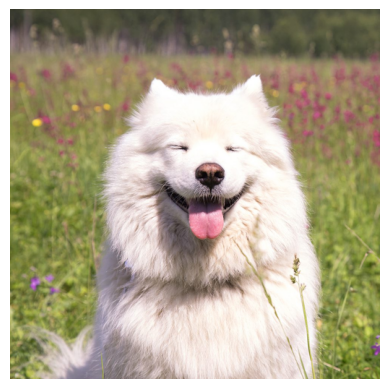

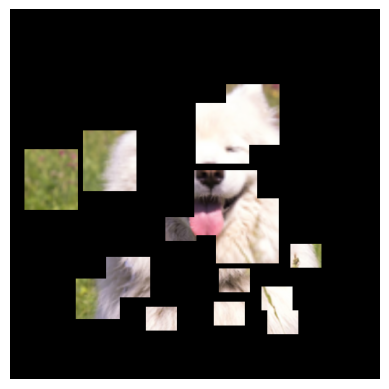

In [21]:
batch_idx = 0
gt_reconstruction = reconstruction_gt(
    g_crops=torch.stack([to_tensor(x) for x in gx_unnorm]),
    l_crops=torch.stack([to_tensor(x) for x in lx_unnorm]),
    # g_crops = io["g_x"][batch_idx],
    # l_crops = io["l_x"][batch_idx],
    g_patch_positions_nopos=io["g_patch_positions_nopos"][batch_idx],
    l_patch_positions_nopos=io["l_patch_positions_nopos"][batch_idx],
    patch_size=patch_size,
    canonical_img_size=512,
    g_shapes=io["g_shapes"],
    l_shapes=io["l_shapes"],
    g_crop_params=io["g_crop_params"][batch_idx],
    l_crop_params=io["l_crop_params"][batch_idx],
)
fig, ax = plt.subplots(1, 1)
# remove axis
ax.axis("off")
ax.imshow(cx)
fig, ax = plt.subplots(1, 1)
ax.imshow(gt_reconstruction.permute(1, 2, 0))
ax.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

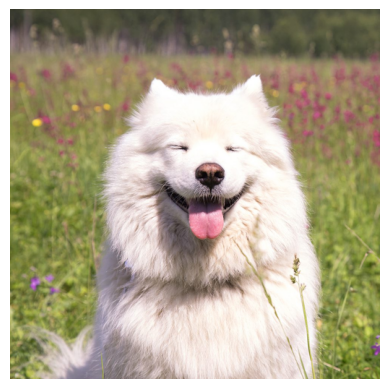

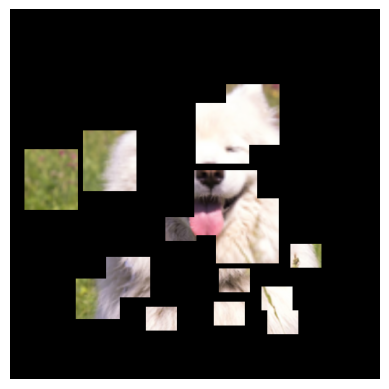

In [22]:
batch_idx = 0
gt_reconstruction = reconstruction_gt(
    g_crops=torch.stack([to_tensor(x) for x in gx_unnorm]),
    l_crops=torch.stack([to_tensor(x) for x in lx_unnorm]),
    # g_crops = io["g_x"][batch_idx],
    # l_crops = io["l_x"][batch_idx],
    g_patch_positions_nopos=io["g_patch_positions_nopos"][batch_idx],
    l_patch_positions_nopos=io["l_patch_positions_nopos"][batch_idx],
    patch_size=patch_size,
    canonical_img_size=512,
    g_shapes=io["g_shapes"],
    l_shapes=io["l_shapes"],
    g_crop_params=io["g_crop_params"][batch_idx],
    l_crop_params=io["l_crop_params"][batch_idx],
)
fig, ax = plt.subplots(1, 1)
# remove axis
ax.axis("off")
ax.imshow(cx)
fig, ax = plt.subplots(1, 1)
ax.imshow(gt_reconstruction.permute(1, 2, 0))
ax.axis("off")

torch.Size([1, 17, 17, 2])


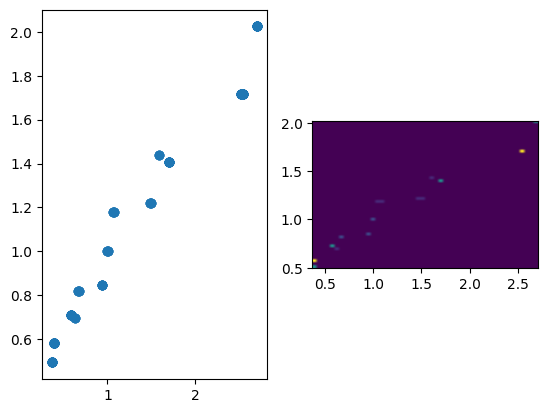

In [23]:
# plot the positions and scales
# patch scales

ds = out["gt_dT"][..., 2:] * math.log(6)
ds = ds.exp()
_, local_N, lV = out["l_shapes"]
_, global_N, gV = out["g_shapes"]
B = 1
device = "cpu"
global_labels = torch.arange(gV, device=device).repeat_interleave(global_N)
local_labels = torch.arange(gV, gV + lV, device=device).repeat_interleave(local_N)
labels = torch.cat([global_labels, local_labels], dim=0)  # [T]
intra_mask = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()  # [T, T]
intra_mask = intra_mask.unsqueeze(0).unsqueeze(-1).expand(B, -1, -1, 1)  # [B, T, T, 1]
inter_mask = 1 - intra_mask
# repeat dim=3
inter_mask = inter_mask.repeat(1, 1, 1, 2)


print(inter_mask.shape)
ds = ds[inter_mask.bool()].view(-1, 2)
fig, ax = plt.subplots(1, 2)
ax[0].scatter(ds[:, 0], ds[:, 1])

# plot heatmap instead of scatter using matplotlib
import numpy as np


heatmap, xedges, yedges = np.histogram2d(ds[:, 0], ds[:, 1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
ax[1].imshow(heatmap.T, extent=extent, origin="lower")
plt.show()